In [1]:
import os
import pandas as pd
import numpy as np
import re

In [2]:
data_path = os.path.join(os.getcwd(), 'data')

datasets = []

for file in os.listdir(data_path):
    key = os.path.splitext(file)[0]
    globals()[key] = pd.read_csv(os.path.join(data_path, file))
    datasets.append(globals()[key])

# Datasets' first impression

## `results`

In [3]:
results

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26075,26081,1110,817,213,3,19,16,16,16,0.0,44,+1:43.071,5053521,25,15,1:50.994,227.169,1
26076,26082,1110,858,3,2,18,17,17,17,0.0,44,+1:44.476,5054926,37,9,1:50.486,228.213,1
26077,26083,1110,807,210,27,0,18,18,18,0.0,44,+1:50.450,5060900,26,4,1:49.907,229.415,1
26078,26084,1110,832,6,55,4,\N,R,19,0.0,23,\N,\N,9,19,1:53.138,222.864,130


In [4]:
results[results['statusId'] == 2]

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
21,22,18,22,11,17,10,\N,D,22,0.0,58,\N,\N,44,8,1:28.736,215.141,2
498,499,41,13,6,5,5,\N,D,21,0.0,51,\N,\N,22,4,1:16.849,204.291,2
499,500,41,21,4,3,9,\N,D,22,0.0,51,\N,\N,22,7,1:17.411,202.808,2
1004,1005,64,27,13,19,21,\N,D,21,0.0,66,\N,\N,35,15,1:18.247,210.441,2
1005,1006,64,33,13,18,18,\N,D,22,0.0,66,\N,\N,46,16,1:18.718,209.182,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24135,24141,1006,839,10,31,6,\N,D,19,0.0,56,\N,\N,\N,0,\N,\N,2
24136,24142,1006,825,210,20,12,\N,D,20,0.0,56,\N,\N,\N,0,\N,\N,2
24538,24544,1026,817,4,3,16,\N,D,19,0.0,51,\N,\N,48,11,1:33.481,223.630,2
24539,24545,1026,807,4,27,15,\N,D,20,0.0,51,\N,\N,47,15,1:34.921,220.237,2


In [5]:
for col in results.columns:
    missing_values = (results[col] == '\\N').sum()
    print(f'{col}: {missing_values}')

resultId: 0
raceId: 0
driverId: 0
constructorId: 0
number: 6
grid: 0
position: 10873
positionText: 0
positionOrder: 0
points: 0
laps: 0
time: 18829
milliseconds: 18830
fastestLap: 18465
rank: 18249
fastestLapTime: 18465
fastestLapSpeed: 18465
statusId: 0


- Maintain Id columns to merge than remove them
- `number` not necessary (idea: transform to binary previousChampion based on if the number is 1)
- in `grid` value 0 means started from pitlane (?)
- `position` and `positionText` show the same information, and `positionOrder` has a slightly difference (idea: two variables - `positionOrder` & binary about the retirements)
- `time` and `milliseconds` show the same information
- `rank`, `fastestLapTime` & `fastestLapSpeed` show the same information

## `driver_standings`

In [6]:
driver_standings

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0
...,...,...,...,...,...,...,...
34119,72183,1110,846,69.0,8,8,0
34120,72184,1110,839,35.0,10,10,0
34121,72185,1110,844,99.0,5,5,0
34122,72186,1110,857,34.0,11,11,0


- `position` and `positionText` have the same information

## `constructor_results`

In [7]:
constructor_results

,constructorResultsId,raceId,constructorId,points,status
0,1,18,1,14.0,\N
1,2,18,2,8.0,\N
2,3,18,3,9.0,\N
3,4,18,4,5.0,\N
4,5,18,5,2.0,\N
...,...,...,...,...,...
12285,16785,1110,214,10.0,\N
12286,16786,1110,213,1.0,\N
12287,16787,1110,51,0.0,\N
12288,16788,1110,3,0.0,\N


In [8]:
constructor_results[~(constructor_results['status'] == '\\N')]

,constructorResultsId,raceId,constructorId,points,status
185,186,36,1,14.0,D
195,196,37,1,18.0,D
207,208,38,1,12.0,D
218,219,39,1,14.0,D
228,229,40,1,18.0,D
239,240,41,1,12.0,D
250,251,42,1,18.0,D
262,263,43,1,8.0,D
273,274,44,1,14.0,D
283,284,45,1,10.0,D


In [9]:
for col in constructor_results.columns:
    missing_values = (constructor_results[col] == '\\N').sum()
    print(f'{col}: {missing_values}')

constructorResultsId: 0
raceId: 0
constructorId: 0
points: 0
status: 12273


- `status` is almost only missing values

## `constructor_standings`

In [10]:
constructor_standings

,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0
...,...,...,...,...,...,...,...
13046,28568,1110,214,57.0,6,6,0
13047,28569,1110,3,11.0,7,7,0
13048,28570,1110,213,3.0,10,10,0
13049,28571,1110,210,11.0,8,8,0


- `position` and `positionText` have the same information

## `races`

In [11]:
races

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,1116,2023,18,69,United States Grand Prix,2023-10-22,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00
1097,1117,2023,19,32,Mexico City Grand Prix,2023-10-29,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N
1098,1118,2023,20,18,São Paulo Grand Prix,2023-11-05,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00
1099,1119,2023,21,80,Las Vegas Grand Prix,2023-11-19,06:00:00,https://en.wikipedia.org/wiki/2023_Las_Vegas_G...,2023-11-17,04:30:00,2023-11-17,08:00:00,2023-11-18,04:30:00,2023-11-18,08:00:00,\N,\N


- `name` not necessary
- extract month from `date` (day probably not necessary)
- `time` in +12 GMT do not say very much (idea: try to transform it into local time)
- last group of variables have to be evaluated

## `circuits`

In [12]:
circuits

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park
...,...,...,...,...,...,...,...,...,...
72,75,portimao,Autódromo Internacional do Algarve,Portimão,Portugal,37.22700,-8.62670,108,http://en.wikipedia.org/wiki/Algarve_Internati...
73,76,mugello,Autodromo Internazionale del Mugello,Mugello,Italy,43.99750,11.37190,255,http://en.wikipedia.org/wiki/Mugello_Circuit
74,77,jeddah,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,21.63190,39.10440,15,http://en.wikipedia.org/wiki/Jeddah_Street_Cir...
75,78,losail,Losail International Circuit,Al Daayen,Qatar,25.49000,51.45420,\N,http://en.wikipedia.org/wiki/Losail_Internatio...


- `circuitRef` probably better than `name`
- `circuitRef` is very similar with `location`

## `drivers`

In [13]:
drivers

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen
...,...,...,...,...,...,...,...,...,...
852,854,mick_schumacher,47,MSC,Mick,Schumacher,1999-03-22,German,http://en.wikipedia.org/wiki/Mick_Schumacher
853,855,zhou,24,ZHO,Guanyu,Zhou,1999-05-30,Chinese,http://en.wikipedia.org/wiki/Zhou_Guanyu
854,856,de_vries,21,DEV,Nyck,de Vries,1995-02-06,Dutch,http://en.wikipedia.org/wiki/Nyck_de_Vries
855,857,piastri,81,PIA,Oscar,Piastri,2001-04-06,Australian,http://en.wikipedia.org/wiki/Oscar_Piastri


- `driverRef` better than `code`, `forename` and `surname`
- `number` not necessary
- `dob` convert it into the age of the driver in the day of the race

## `constructors`

In [14]:
constructors

,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso
...,...,...,...,...,...
206,209,manor,Manor Marussia,British,http://en.wikipedia.org/wiki/Manor_Motorsport
207,210,haas,Haas F1 Team,American,http://en.wikipedia.org/wiki/Haas_F1_Team
208,211,racing_point,Racing Point,British,http://en.wikipedia.org/wiki/Racing_Point_F1_Team
209,213,alphatauri,AlphaTauri,Italian,http://en.wikipedia.org/wiki/Scuderia_AlphaTauri


- `constructorRef` better than `name`

## `status`

In [15]:
status

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine
...,...,...
134,137,Damage
135,138,Debris
136,139,Illness
137,140,Undertray


## `qualifying`

In [16]:
qualifying

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236
...,...,...,...,...,...,...,...,...,...
9810,9868,1110,848,3,23,16,2:00.314,\N,\N
9811,9869,1110,855,51,24,17,2:00.832,\N,\N
9812,9870,1110,858,3,2,18,2:01.535,\N,\N
9813,9871,1110,817,213,3,19,2:02.159,\N,\N


- `number` not necessary
- there are obviously many missing values in `q2` and `q3` idea

## `lap_times`

In [17]:
lap_times

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342
...,...,...,...,...,...,...
551737,1110,817,40,17,1:54.361,114361
551738,1110,817,41,17,1:53.367,113367
551739,1110,817,42,16,1:55.247,115247
551740,1110,817,43,16,1:52.115,112115


## `pit_stops`

In [18]:
pit_stops

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842
...,...,...,...,...,...,...,...
10084,1110,4,2,29,15:59:01,23.798,23798
10085,1110,830,2,30,16:00:16,23.012,23012
10086,1110,848,3,33,16:07:06,23.529,23529
10087,1110,858,3,34,16:09:09,23.109,23109


## `sprint_results`

In [19]:
sprint_results

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId
0,1,1061,830,9,33,2,1,1,1,3,17,25:38.426,1538426,14,1:30.013,1
1,2,1061,1,131,44,1,2,2,2,2,17,+1.430,1539856,17,1:29.937,1
2,3,1061,822,131,77,3,3,3,3,1,17,+7.502,1545928,17,1:29.958,1
3,4,1061,844,6,16,4,4,4,4,0,17,+11.278,1549704,16,1:30.163,1
4,5,1061,846,1,4,6,5,5,5,0,17,+24.111,1562537,16,1:30.566,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,1110,858,3,2,13,16,16,16,0,11,+37.571,1536004,6,2:03.482,1
176,177,1110,807,210,27,20,17,17,17,0,11,+37.827,1536260,6,2:03.472,1
177,178,1110,852,213,22,16,18,18,18,0,11,+39.267,1537700,7,2:02.080,1
178,179,1110,815,9,11,8,\N,R,19,0,8,\N,\N,2,2:02.516,130


# Merging

In [20]:
merged_data = pd.merge(results, races, on='raceId')
merged_data2 = pd.merge(merged_data, drivers, on='driverId')
merged_data3 = pd.merge(merged_data2, constructors, on='constructorId')
merged_data4 = pd.merge(merged_data3, status, on='statusId')
merged_data5 = pd.merge(merged_data4, circuits, on='circuitId')

C:\Users\Afonso Cadete\AppData\Local\Temp\ipykernel_19668\813418794.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'url_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_data5 = pd.merge(merged_data4, circuits, on='circuitId')


In [21]:
merged_data5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26080 entries, 0 to 26079
Data columns (total 56 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         26080 non-null  int64  
 1   raceId           26080 non-null  int64  
 2   driverId         26080 non-null  int64  
 3   constructorId    26080 non-null  int64  
 4   number_x         26080 non-null  object 
 5   grid             26080 non-null  int64  
 6   position         26080 non-null  object 
 7   positionText     26080 non-null  object 
 8   positionOrder    26080 non-null  int64  
 9   points           26080 non-null  float64
 10  laps             26080 non-null  int64  
 11  time_x           26080 non-null  object 
 12  milliseconds     26080 non-null  object 
 13  fastestLap       26080 non-null  object 
 14  rank             26080 non-null  object 
 15  fastestLapTime   26080 non-null  object 
 16  fastestLapSpeed  26080 non-null  object 
 17  statusId    

In [22]:
merged_data5.drop(columns=merged_data5.filter(regex='Id|number|url|name|fp|quali|sprint').columns, inplace=True)

In [23]:
merged_data5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26080 entries, 0 to 26079
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   grid             26080 non-null  int64  
 1   position         26080 non-null  object 
 2   positionText     26080 non-null  object 
 3   positionOrder    26080 non-null  int64  
 4   points           26080 non-null  float64
 5   laps             26080 non-null  int64  
 6   time_x           26080 non-null  object 
 7   milliseconds     26080 non-null  object 
 8   fastestLap       26080 non-null  object 
 9   rank             26080 non-null  object 
 10  fastestLapTime   26080 non-null  object 
 11  fastestLapSpeed  26080 non-null  object 
 12  year             26080 non-null  int64  
 13  round            26080 non-null  int64  
 14  date             26080 non-null  object 
 15  time_y           26080 non-null  object 
 16  driverRef        26080 non-null  object 
 17  code        

In [24]:
data2223 = merged_data5[merged_data5['year'].isin([2022, 2023])]

In [25]:
data2223.T

,26,29,30,31,38,39,49,74,134,136,...,25028,25029,25030,25031,25032,25033,25034,25035,25036,25037
grid,7,4,13,16,5,3,6,20,5,1,...,9,17,15,19,20,8,0,7,17,16
position,6,5,6,8,4,2,3,10,12,1,...,12,11,18,19,20,\N,17,\N,\N,16
positionText,6,5,6,8,4,2,3,10,12,1,...,12,11,18,19,20,R,17,R,R,16
positionOrder,6,5,6,8,4,2,3,10,12,1,...,12,11,18,19,20,19,17,18,20,16
points,8.0,10.0,8.0,4.0,12.0,18.0,15.0,1.0,0.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
laps,58,58,58,58,58,58,58,58,58,58,...,57,57,57,56,56,39,54,45,6,56
time_x,+53.737,+53.303,+3.701,+5.382,+28.543,+0.179,+25.593,+1:19.382,+6.594,1:27:46.548,...,+40.146,+1:04.309,+1:28.949,\N,\N,\N,\N,\N,\N,\N
milliseconds,5320285,5319851,9162072,9163753,5295091,9158550,5292141,5345930,9164965,5266548,...,5704404,5322550,5347190,\N,\N,\N,\N,\N,\N,\N
fastestLap,54,55,46,53,51,49,53,54,53,58,...,55,56,57,56,50,37,50,38,4,52
rank,9,8,9,12,7,5,4,12,3,1,...,8,8,12,18,19,14,16,19,20,17


In [26]:
data2223.drop(columns=['position', 'positionText', 'code'], inplace=True)

C:\Users\Afonso Cadete\AppData\Local\Temp\ipykernel_19668\1553771130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2223.drop(columns=['position', 'positionText', 'code'], inplace=True)


In [27]:
data2223.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 26 to 25037
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   grid             680 non-null    int64  
 1   positionOrder    680 non-null    int64  
 2   points           680 non-null    float64
 3   laps             680 non-null    int64  
 4   time_x           680 non-null    object 
 5   milliseconds     680 non-null    object 
 6   fastestLap       680 non-null    object 
 7   rank             680 non-null    object 
 8   fastestLapTime   680 non-null    object 
 9   fastestLapSpeed  680 non-null    object 
 10  year             680 non-null    int64  
 11  round            680 non-null    int64  
 12  date             680 non-null    object 
 13  time_y           680 non-null    object 
 14  driverRef        680 non-null    object 
 15  dob              680 non-null    object 
 16  nationality_x    680 non-null    object 
 17  constructorRe

# Missing Values

In [28]:
data2223.replace('\\N', np.nan, inplace=True)

C:\Users\Afonso Cadete\AppData\Local\Temp\ipykernel_19668\1418711449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2223.replace('\\N', np.nan, inplace=True)


In [30]:
data2223.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 26 to 25037
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   grid             680 non-null    int64  
 1   positionOrder    680 non-null    int64  
 2   points           680 non-null    float64
 3   laps             680 non-null    int64  
 4   time_x           442 non-null    object 
 5   milliseconds     442 non-null    object 
 6   fastestLap       662 non-null    object 
 7   rank             680 non-null    object 
 8   fastestLapTime   662 non-null    object 
 9   fastestLapSpeed  662 non-null    object 
 10  year             680 non-null    int64  
 11  round            680 non-null    int64  
 12  date             680 non-null    object 
 13  time_y           680 non-null    object 
 14  driverRef        680 non-null    object 
 15  dob              680 non-null    object 
 16  nationality_x    680 non-null    object 
 17  constructorRe

In [29]:
# def convert_to_float(var):
#     try:
#         return float(var)
#     except (ValueError, TypeError):
#         return var  # Return the variable itself if it can't be converted


# for col in data2223.columns:
#     data2223[col] = data2223[col].apply(convert_to_float)

In [30]:
data2223.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 26 to 25037
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   grid             680 non-null    int64  
 1   positionOrder    680 non-null    int64  
 2   points           680 non-null    float64
 3   laps             680 non-null    int64  
 4   time_x           442 non-null    object 
 5   milliseconds     442 non-null    object 
 6   fastestLap       662 non-null    object 
 7   rank             680 non-null    object 
 8   fastestLapTime   662 non-null    object 
 9   fastestLapSpeed  662 non-null    object 
 10  year             680 non-null    int64  
 11  round            680 non-null    int64  
 12  date             680 non-null    object 
 13  time_y           680 non-null    object 
 14  driverRef        680 non-null    object 
 15  dob              680 non-null    object 
 16  nationality_x    680 non-null    object 
 17  constructorRe

## `alt`

In [31]:
data2223['alt'].fillna(7, inplace=True)
# https://www.freemaptools.com/elevation-finder.htm

C:\Users\Afonso Cadete\AppData\Local\Temp\ipykernel_19668\256530716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2223['alt'].fillna(7, inplace=True)


## `time_x`, `milliseconds` & `delta`

In [34]:
data2223

,grid,positionOrder,points,laps,time_x,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,...,nationality_x,constructorRef,nationality_y,status,circuitRef,location,country,lat,lng,alt
26,7,6,8.0,58,+53.737,5320285,54,9,1:22.451,230.449,...,Australian,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10
29,4,5,10.0,58,+53.303,5319851,55,8,1:22.248,231.018,...,British,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10
30,13,6,8.0,58,+3.701,9162072,46,9,1:21.173,234.077,...,British,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10
31,16,8,4.0,58,+5.382,9163753,53,12,1:21.335,233.611,...,Australian,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10
38,5,4,12.0,58,+28.543,5295091,51,7,1:21.886,232.039,...,British,mercedes,German,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25033,8,19,0.0,39,NaN,NaN,37,14,1:33.411,208.575,...,British,mclaren,British,Collision,miami,Miami,USA,25.9581,-80.2389,7
25034,0,17,0.0,54,NaN,NaN,50,16,1:33.479,208.423,...,German,aston_martin,British,Collision,miami,Miami,USA,25.9581,-80.2389,7
25035,7,18,0.0,45,NaN,NaN,38,19,1:34.487,206.199,...,French,alphatauri,Italian,Suspension,miami,Miami,USA,25.9581,-80.2389,7
25036,17,20,0.0,6,NaN,NaN,4,20,1:35.731,203.520,...,Chinese,alfa,Swiss,Water leak,miami,Miami,USA,25.9581,-80.2389,7


In [37]:
data2223[data2223['status'] != 'Finished']['status'].value_counts()

+1 Lap              124
Collision damage     18
Collision            15
Accident             12
Engine               12
+2 Laps              11
Power Unit            6
Gearbox               4
Hydraulics            4
Brakes                2
Power loss            2
Mechanical            2
Water pressure        2
Oil leak              2
Water leak            2
Undertray             2
Spun off              2
Fuel pressure         2
Differential          1
Water pump            1
Withdrew              1
Cooling system        1
Suspension            1
+6 Laps               1
Turbo                 1
Overheating           1
Vibrations            1
Electrical            1
Retired               1
Fuel pump             1
Fuel leak             1
Front wing            1
Name: status, dtype: int64

In [32]:
def convert_to_milliseconds(time_str):
    if pd.isnull(time_str):  # Check for 'nan'
        return np.nan  # Return 'nan' value
    
    minutes, seconds = map(float, str(time_str).split(':'))
    total_seconds = (minutes * 60) + seconds
    milliseconds = total_seconds * 1000
    return milliseconds

data2223['fastestLapTime'] = data2223['fastestLapTime'].apply(convert_to_milliseconds)

C:\Users\Afonso Cadete\AppData\Local\Temp\ipykernel_11648\330954300.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2223['fastestLapTime'] = data2223['fastestLapTime'].apply(convert_to_milliseconds)


In [33]:
data2223[data2223['status'].str.contains('Lap')]

,grid,positionOrder,points,laps,time_x,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,...,nationality_x,constructorRef,nationality_y,status,circuitRef,location,country,lat,lng,alt
223,18,16,0.0,57,NaN,NaN,49,18,83882.0,226.518,...,Canadian,williams,British,+1 Lap,albert_park,Melbourne,Australia,-37.8497,144.96800,10
245,10,17,0.0,57,NaN,NaN,57,2,80846.0,235.024,...,Spanish,alpine,French,+1 Lap,albert_park,Melbourne,Australia,-37.8497,144.96800,10
286,16,14,0.0,57,NaN,NaN,44,15,83071.0,228.729,...,Danish,haas,American,+1 Lap,albert_park,Melbourne,Australia,-37.8497,144.96800,10
287,15,13,0.0,57,NaN,NaN,55,14,83006.0,228.908,...,German,haas,American,+1 Lap,albert_park,Melbourne,Australia,-37.8497,144.96800,10
290,13,15,0.0,57,NaN,NaN,56,16,83342.0,227.985,...,Japanese,alphatauri,Italian,+1 Lap,albert_park,Melbourne,Australia,-37.8497,144.96800,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21907,20,18,0.0,71,NaN,NaN,62,18,76066.0,201.567,...,Canadian,williams,British,+1 Lap,zandvoort,Zandvoort,Netherlands,52.3888,4.54092,6
24980,13,13,0.0,49,NaN,NaN,46,16,94446.0,235.334,...,Canadian,aston_martin,British,+1 Lap,jeddah,Jeddah,Saudi Arabia,21.6319,39.10440,15
24982,14,18,0.0,49,NaN,NaN,37,17,94384.0,235.489,...,Finnish,alfa,Swiss,+1 Lap,jeddah,Jeddah,Saudi Arabia,21.6319,39.10440,15
25031,19,19,0.0,56,NaN,NaN,56,18,92006.0,211.760,...,Australian,mclaren,British,+1 Lap,miami,Miami,USA,25.9581,-80.23890,7


In [34]:
data2223['milliseconds'] = data2223['milliseconds'].astype(float)

C:\Users\Afonso Cadete\AppData\Local\Temp\ipykernel_11648\1648885188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2223['milliseconds'] = data2223['milliseconds'].astype(float)


In [35]:
lastFinisherTime = data2223.groupby('date')['milliseconds'].max()

In [36]:
data2223 = pd.merge(
    data2223,
    lastFinisherTime,
    on=['date'],
    suffixes=('', 'LastFinisher'),
    how='left'
)

In [48]:
def calculate_missing_milliseconds(row):
    if pd.isnull(row['milliseconds']):
        laps_missing = 0
        if '+1 Lap' in row['status']:
            laps_missing = 1
        elif '+2 Laps' in row['status']:
            laps_missing = 2
        elif '+6 Laps' in row['status']:
            laps_missing = 6
        elif row['status'] != 'Finished':
            laps_missing = 10
        
        if laps_missing > 0:
            return row['millisecondsLastFinisher'] + laps_missing * row['fastestLapTime']
    
    return row['milliseconds']

# Apply the function to fill missing milliseconds
data2223['milliseconds'] = data2223.apply(calculate_missing_milliseconds, axis=1)
data2223.drop(columns=['millisecondsLastFinisher'], inplace=True)

In [49]:
data2223[data2223['status'].str.contains('Lap')]

,grid,positionOrder,points,laps,time_x,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,...,nationality_x,constructorRef,nationality_y,status,circuitRef,location,country,lat,lng,alt
24,18,16,0.0,57,NaN,5439028.0,49,18,83882.0,226.518,...,Canadian,williams,British,+1 Lap,albert_park,Melbourne,Australia,-37.8497,144.96800,10
25,10,17,0.0,57,NaN,5435992.0,57,2,80846.0,235.024,...,Spanish,alpine,French,+1 Lap,albert_park,Melbourne,Australia,-37.8497,144.96800,10
26,16,14,0.0,57,NaN,5438217.0,44,15,83071.0,228.729,...,Danish,haas,American,+1 Lap,albert_park,Melbourne,Australia,-37.8497,144.96800,10
27,15,13,0.0,57,NaN,5438152.0,55,14,83006.0,228.908,...,German,haas,American,+1 Lap,albert_park,Melbourne,Australia,-37.8497,144.96800,10
28,13,15,0.0,57,NaN,5438488.0,56,16,83342.0,227.985,...,Japanese,alphatauri,Italian,+1 Lap,albert_park,Melbourne,Australia,-37.8497,144.96800,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,20,18,0.0,71,NaN,5916603.0,62,18,76066.0,201.567,...,Canadian,williams,British,+1 Lap,zandvoort,Zandvoort,Netherlands,52.3888,4.54092,6
629,13,13,0.0,49,NaN,5245481.0,46,16,94446.0,235.334,...,Canadian,aston_martin,British,+1 Lap,jeddah,Jeddah,Saudi Arabia,21.6319,39.10440,15
630,14,18,0.0,49,NaN,5055723.0,37,17,94384.0,235.489,...,Finnish,alfa,Swiss,+1 Lap,jeddah,Jeddah,Saudi Arabia,21.6319,39.10440,15
673,19,19,0.0,56,NaN,5439196.0,56,18,92006.0,211.760,...,Australian,mclaren,British,+1 Lap,miami,Miami,USA,25.9581,-80.23890,7


## `fastestLap`, `fastestLapTime` & `lastestLapSpeed`

In [50]:
data2223.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 0 to 679
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   grid             680 non-null    int64  
 1   positionOrder    680 non-null    int64  
 2   points           680 non-null    float64
 3   laps             680 non-null    int64  
 4   time_x           442 non-null    object 
 5   milliseconds     662 non-null    float64
 6   fastestLap       662 non-null    object 
 7   rank             680 non-null    object 
 8   fastestLapTime   662 non-null    float64
 9   fastestLapSpeed  662 non-null    object 
 10  year             680 non-null    int64  
 11  round            680 non-null    int64  
 12  date             680 non-null    object 
 13  time_y           680 non-null    object 
 14  driverRef        680 non-null    object 
 15  dob              680 non-null    object 
 16  nationality_x    680 non-null    object 
 17  constructorRef  

In [54]:
data2223

,grid,positionOrder,points,laps,time_x,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,...,nationality_x,constructorRef,nationality_y,status,circuitRef,location,country,lat,lng,alt
0,7,6,8.0,58,+53.737,5320285.0,54,9,82451.0,230.449,...,Australian,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10
1,4,5,10.0,58,+53.303,5319851.0,55,8,82248.0,231.018,...,British,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10
2,13,6,8.0,58,+3.701,9162072.0,46,9,81173.0,234.077,...,British,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10
3,16,8,4.0,58,+5.382,9163753.0,53,12,81335.0,233.611,...,Australian,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10
4,5,4,12.0,58,+28.543,5295091.0,51,7,81886.0,232.039,...,British,mercedes,German,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,8,19,0.0,39,NaN,6671673.0,37,14,93411.0,208.575,...,British,mclaren,British,Collision,miami,Miami,USA,25.9581,-80.2389,7
676,0,17,0.0,54,NaN,6672353.0,50,16,93479.0,208.423,...,German,aston_martin,British,Collision,miami,Miami,USA,25.9581,-80.2389,7
677,7,18,0.0,45,NaN,6682433.0,38,19,94487.0,206.199,...,French,alphatauri,Italian,Suspension,miami,Miami,USA,25.9581,-80.2389,7
678,17,20,0.0,6,NaN,6694873.0,4,20,95731.0,203.520,...,Chinese,alfa,Swiss,Water leak,miami,Miami,USA,25.9581,-80.2389,7


In [53]:
data2223[data2223['fastestLap'].isna()].T

,30,34,151,152,153,198,199,236,237,238,297,298,398,399,439,498,635,637
grid,7,9,8,16,9,12,15,13,5,4,11,8,3,16,1,4,19,0
positionOrder,20,20,18,20,19,19,20,19,20,20,20,19,19,20,20,20,19,20
points,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
laps,0,1,0,0,0,2,1,1,0,0,0,0,0,0,1,0,0,0
time_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
milliseconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fastestLap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rank,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fastestLapTime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fastestLapSpeed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Transformation/Engineering

Engineering:
- `date` - `dob` ---> `age`
- `laps` / max(`laps`[`circuitRef`]) = `lapsPercentage`

In [30]:
# Filter data to exclude rows with '+' in 'time_x' or NaN values
winners = data2223[~(data2223['time_x'].str.contains('\+', na=False) | data2223['time_x'].isna())]

# Merge datasets on specified columns
data2223 = pd.merge(
    data2223,
    winners[['milliseconds', 'year', 'circuitRef']],
    on=['year', 'circuitRef'],
    suffixes=('', 'Winner'),
    how='left'
)

# Calculate 'delta' column using vectorized operations
mask = ~data2223['milliseconds'].isnull()
data2223.loc[mask, 'delta'] = data2223.loc[mask, 'milliseconds'].astype(int) - data2223.loc[mask, 'millisecondsWinner'].astype(int)
data2223.drop(columns=['time_x', 'millisecondsWinner'], inplace=True)

In [31]:
data2223

,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,year,...,constructorRef,nationality_y,status,circuitRef,location,country,lat,lng,alt,delta
0,7,6,8.0,58,5320285,54,9,1:22.451,230.449,2022,...,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10,53737.0
1,4,5,10.0,58,5319851,55,8,1:22.248,231.018,2022,...,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10,53303.0
2,13,6,8.0,58,9162072,46,9,1:21.173,234.077,2023,...,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10,3701.0
3,16,8,4.0,58,9163753,53,12,1:21.335,233.611,2023,...,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10,5382.0
4,5,4,12.0,58,5295091,51,7,1:21.886,232.039,2022,...,mercedes,German,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10,28543.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,8,19,0.0,39,NaN,37,14,1:33.411,208.575,2022,...,mclaren,British,Collision,miami,Miami,USA,25.9581,-80.2389,NaN,NaN
676,0,17,0.0,54,NaN,50,16,1:33.479,208.423,2022,...,aston_martin,British,Collision,miami,Miami,USA,25.9581,-80.2389,NaN,NaN
677,7,18,0.0,45,NaN,38,19,1:34.487,206.199,2022,...,alphatauri,Italian,Suspension,miami,Miami,USA,25.9581,-80.2389,NaN,NaN
678,17,20,0.0,6,NaN,4,20,1:35.731,203.520,2022,...,alfa,Swiss,Water leak,miami,Miami,USA,25.9581,-80.2389,NaN,NaN


In [34]:
data2223

,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,year,...,constructorRef,nationality_y,status,circuitRef,location,country,lat,lng,alt,delta
0,7.0,6.0,8.0,58.0,5320285.0,54.0,9.0,82451.0,230.449,2022.0,...,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10.0,53737.0
1,4.0,5.0,10.0,58.0,5319851.0,55.0,8.0,82248.0,231.018,2022.0,...,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10.0,53303.0
2,13.0,6.0,8.0,58.0,9162072.0,46.0,9.0,81173.0,234.077,2023.0,...,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10.0,3701.0
3,16.0,8.0,4.0,58.0,9163753.0,53.0,12.0,81335.0,233.611,2023.0,...,mclaren,British,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10.0,5382.0
4,5.0,4.0,12.0,58.0,5295091.0,51.0,7.0,81886.0,232.039,2022.0,...,mercedes,German,Finished,albert_park,Melbourne,Australia,-37.8497,144.9680,10.0,28543.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,8.0,19.0,0.0,39.0,NaN,37.0,14.0,93411.0,208.575,2022.0,...,mclaren,British,Collision,miami,Miami,USA,25.9581,-80.2389,NaN,NaN
676,0.0,17.0,0.0,54.0,NaN,50.0,16.0,93479.0,208.423,2022.0,...,aston_martin,British,Collision,miami,Miami,USA,25.9581,-80.2389,NaN,NaN
677,7.0,18.0,0.0,45.0,NaN,38.0,19.0,94487.0,206.199,2022.0,...,alphatauri,Italian,Suspension,miami,Miami,USA,25.9581,-80.2389,NaN,NaN
678,17.0,20.0,0.0,6.0,NaN,4.0,20.0,95731.0,203.520,2022.0,...,alfa,Swiss,Water leak,miami,Miami,USA,25.9581,-80.2389,NaN,NaN


In [35]:
data2223.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 0 to 679
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   grid             680 non-null    float64
 1   positionOrder    680 non-null    float64
 2   points           680 non-null    float64
 3   laps             680 non-null    float64
 4   milliseconds     442 non-null    float64
 5   fastestLap       662 non-null    float64
 6   rank             680 non-null    float64
 7   fastestLapTime   662 non-null    float64
 8   fastestLapSpeed  662 non-null    float64
 9   year             680 non-null    float64
 10  round            680 non-null    float64
 11  date             680 non-null    object 
 12  time_y           680 non-null    object 
 13  driverRef        680 non-null    object 
 14  dob              680 non-null    object 
 15  nationality_x    680 non-null    object 
 16  constructorRef   680 non-null    object 
 17  nationality_y   

In [36]:
data2223.T

,0,1,2,3,4,5,6,7,8,9,...,670,671,672,673,674,675,676,677,678,679
grid,7.0,4.0,13.0,16.0,5.0,3.0,6.0,20.0,5.0,1.0,...,9.0,17.0,15.0,19.0,20.0,8.0,0.0,7.0,17.0,16.0
positionOrder,6.0,5.0,6.0,8.0,4.0,2.0,3.0,10.0,12.0,1.0,...,12.0,11.0,18.0,19.0,20.0,19.0,17.0,18.0,20.0,16.0
points,8.0,10.0,8.0,4.0,12.0,18.0,15.0,1.0,0.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
laps,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,...,57.0,57.0,57.0,56.0,56.0,39.0,54.0,45.0,6.0,56.0
milliseconds,5320285.0,5319851.0,9162072.0,9163753.0,5295091.0,9158550.0,5292141.0,5345930.0,9164965.0,5266548.0,...,5704404.0,5322550.0,5347190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fastestLap,54.0,55.0,46.0,53.0,51.0,49.0,53.0,54.0,53.0,58.0,...,55.0,56.0,57.0,56.0,50.0,37.0,50.0,38.0,4.0,52.0
rank,9.0,8.0,9.0,12.0,7.0,5.0,4.0,12.0,3.0,1.0,...,8.0,8.0,12.0,18.0,19.0,14.0,16.0,19.0,20.0,17.0
fastestLapTime,82451.0,82248.0,81173.0,81335.0,81886.0,80613.0,81495.0,82589.0,80467.0,80260.0,...,93035.0,91038.0,91562.0,92006.0,92384.0,93411.0,93479.0,94487.0,95731.0,93511.0
fastestLapSpeed,230.449,231.018,234.077,233.611,232.039,235.703,233.152,230.064,236.131,236.74,...,209.417,214.011,212.786,211.76,210.893,208.575,208.423,206.199,203.52,208.351
year,2022.0,2022.0,2023.0,2023.0,2022.0,2023.0,2022.0,2022.0,2023.0,2022.0,...,2022.0,2023.0,2023.0,2023.0,2023.0,2022.0,2022.0,2022.0,2022.0,2022.0


In [37]:
data2223['date'] = pd.to_datetime(data2223['date'])
data2223['dob'] = pd.to_datetime(data2223['dob'])

data2223['month'] = data2223['date'].dt.month

# Calculate age by subtracting 'dob' from 'date'
data2223['age'] = (data2223['date'] - data2223['dob']).dt.days // 365

# Display the DataFrame with the new 'age' variable
data2223[['driverRef', 'dob', 'date', 'age']]

,driverRef,dob,date,age
0,ricciardo,1989-07-01,2022-04-10,32
1,norris,1999-11-13,2022-04-10,22
2,norris,1999-11-13,2023-04-02,23
3,piastri,2001-04-06,2023-04-02,22
4,hamilton,1985-01-07,2022-04-10,37
...,...,...,...,...
675,norris,1999-11-13,2022-05-08,22
676,vettel,1987-07-03,2022-05-08,34
677,gasly,1996-02-07,2022-05-08,26
678,zhou,1999-05-30,2022-05-08,22


In [38]:
# from pytz import timezone
# from geopy.geocoders import Nominatim
# from datetime import datetime, timedelta

# Assuming your data is stored in a DataFrame called 'data'
# Convert 'time_y' column to datetime format
data2223['time_y'] = pd.to_datetime(data2223['time_y'])

# # Function to convert time from +12 GMT to local time
# def convert_to_local_time(row):
#     # Get the location information (latitude and longitude)
#     location = f"{row['location']}, {row['country']}"
#     geolocator = Nominatim(user_agent="geoapiExercises")
#     location = geolocator.geocode(location)
    
#     # Get local timezone based on location
#     local_timezone = timezone(timezone(location.raw['timezone']['timezone_identifier']))
    
#     # Convert +12 GMT time to local time
#     time_in_gmt12 = row['time_y'].replace(tzinfo=timezone('GMT+12'))
#     local_time = time_in_gmt12.astimezone(local_timezone)
#     return local_time

# # Apply function to create a new column 'local_race_time'
# data2223['timeLocal'] = data2223.apply(convert_to_local_time, axis=1)


In [39]:
data2223.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 0 to 679
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   grid             680 non-null    float64       
 1   positionOrder    680 non-null    float64       
 2   points           680 non-null    float64       
 3   laps             680 non-null    float64       
 4   milliseconds     442 non-null    float64       
 5   fastestLap       662 non-null    float64       
 6   rank             680 non-null    float64       
 7   fastestLapTime   662 non-null    float64       
 8   fastestLapSpeed  662 non-null    float64       
 9   year             680 non-null    float64       
 10  round            680 non-null    float64       
 11  date             680 non-null    datetime64[ns]
 12  time_y           680 non-null    datetime64[ns]
 13  driverRef        680 non-null    object        
 14  dob              680 non-null    datetime6

In [40]:
datetime_columns = data2223.select_dtypes(include=['datetime']).columns
data2223.drop(columns=datetime_columns, inplace=True)

# Data Preparation

In [41]:
# DATA TYPES
def datatype_distinction(data):
    '''
    Distinguishes between the numerical and categorical columns in a DataFrame.

    Parameters:
    -----------
    data : pandas.DataFrame
        The input DataFrame.

    Returns:
    --------
    numerical : pandas.DataFrame
        DataFrame containing only numerical columns.

    categorical : pandas.DataFrame
        DataFrame containing only categorical columns.
    '''
    # Select numerical columns using select_dtypes with np.number
    numerical = data.select_dtypes(include=np.number).copy()
    
    # Select categorical columns by excluding numerical types
    categorical = data.select_dtypes(exclude=np.number).copy()
    
    return numerical, categorical


# DATA TRANSFORMATION
def transformation(technique, data, column_transformer=False):
    '''
    Applies the specified transformation technique to the DataFrame.

    Parameters:
    -----------
    technique : object
        The transformation technique (e.g., from Scikit-learn) to be applied.

    data : pandas.DataFrame
        The input DataFrame to be transformed.

    column_transformer : bool, optional (default=False)
        Flag to indicate if a column transformer is used for custom column names.

    Returns:
    --------
    data_transformed : pandas.DataFrame
        Transformed DataFrame.

    Notes:
    ------
    - If column_transformer is False, the columns in the transformed DataFrame
      will retain the original column names.
    - If column_transformer is True, the method assumes that technique has a
      get_feature_names_out() method and uses it to get feature names for the
      transformed data, otherwise retains the original column names.
    '''
    # Apply the specified transformation technique to the data
    data_transformed = technique.transform(data)
    
    # Create a DataFrame from the transformed data
    data_transformed = pd.DataFrame(
        data_transformed,
        index=data.index,
        columns=technique.get_feature_names_out() if column_transformer else data.columns
    )
    
    return data_transformed


def data_transform(technique, X_train, X_val=None, column_transformer=False):
    '''
    Fits a data transformation technique on the training data and applies the transformation 
    to both the training and validation data.

    Parameters:
    -----------
    technique : object
        The data transformation technique (e.g., from Scikit-learn) to be applied.

    X_train : pandas.DataFrame or array-like
        The training data to fit the transformation technique and transform.

    X_val : pandas.DataFrame or array-like, optional (default=None)
        The validation data to be transformed.

    column_transformer : bool, optional (default=False)
        Flag to indicate if a column transformer is used for custom column names.

    Returns:
    --------
    X_train_transformed : pandas.DataFrame
        Transformed training data.

    X_val_transformed : pandas.DataFrame or None
        Transformed validation data. None if X_val is None.

    Notes:
    ------
    - Fits the transformation technique on the training data (X_train).
    - Applies the fitted transformation to X_train and optionally to X_val if provided.
    '''
    # Fit the transformation technique on the training data
    technique.fit(X_train)
    
    # Apply transformation to the training data
    X_train_transformed = transformation(technique, X_train, column_transformer)
    
    # Apply transformation to the validation data if provided
    X_val_transformed = None
    if X_val is not None:
        X_val_transformed = transformation(technique, X_val, column_transformer)
        
    return X_train_transformed, X_val_transformed

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [43]:
ct = ColumnTransformer([
    ('oneHot', OneHotEncoder(drop='first', sparse=False), [i for i in range(11, 19)])
], remainder='passthrough')

train = data_transform(ct, data2223, column_transformer=True)[0]

c:\Users\Afonso Cadete\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [44]:
train.columns = train.columns.str.replace(r'(oneHot|remainder)__', '')

C:\Users\Afonso Cadete\AppData\Local\Temp\ipykernel_4976\222682236.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train.columns = train.columns.str.replace(r'(oneHot|remainder)__', '')


In [45]:
train

,driverRef_alonso,driverRef_bottas,driverRef_de_vries,driverRef_gasly,driverRef_hamilton,driverRef_hulkenberg,driverRef_kevin_magnussen,driverRef_latifi,driverRef_leclerc,driverRef_max_verstappen,...,fastestLapTime,fastestLapSpeed,year,round,lat,lng,alt,delta,month,age
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,82451.0,230.449,2022.0,3.0,-37.8497,144.9680,10.0,53737.0,4.0,32.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,82248.0,231.018,2022.0,3.0,-37.8497,144.9680,10.0,53303.0,4.0,22.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,81173.0,234.077,2023.0,3.0,-37.8497,144.9680,10.0,3701.0,4.0,23.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,81335.0,233.611,2023.0,3.0,-37.8497,144.9680,10.0,5382.0,4.0,22.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,81886.0,232.039,2022.0,3.0,-37.8497,144.9680,10.0,28543.0,4.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,93411.0,208.575,2022.0,5.0,25.9581,-80.2389,NaN,NaN,5.0,22.0
676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,93479.0,208.423,2022.0,5.0,25.9581,-80.2389,NaN,NaN,5.0,34.0
677,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,94487.0,206.199,2022.0,5.0,25.9581,-80.2389,NaN,NaN,5.0,26.0
678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,95731.0,203.520,2022.0,5.0,25.9581,-80.2389,NaN,NaN,5.0,22.0


In [46]:
X = train.drop(columns='positionOrder')
y = train['positionOrder']

In [47]:
from sklearn.preprocessing import MinMaxScaler

In [48]:
X = data_transform(MinMaxScaler(), X)[0]

In [49]:
X

,driverRef_alonso,driverRef_bottas,driverRef_de_vries,driverRef_gasly,driverRef_hamilton,driverRef_hulkenberg,driverRef_kevin_magnussen,driverRef_latifi,driverRef_leclerc,driverRef_max_verstappen,...,fastestLapTime,fastestLapSpeed,year,round,lat,lng,alt,delta,month,age
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.263586,0.852283,0.0,0.095238,0.000000,1.000000,0.00761,0.486528,0.125,0.523810
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.260120,0.857023,0.0,0.095238,0.000000,1.000000,0.00761,0.482598,0.125,0.047619
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.241767,0.882504,1.0,0.095238,0.000000,1.000000,0.00761,0.033508,0.125,0.095238
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.244532,0.878623,1.0,0.095238,0.000000,1.000000,0.00761,0.048728,0.125,0.047619
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.253940,0.865528,0.0,0.095238,0.000000,1.000000,0.00761,0.258425,0.125,0.761905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.450703,0.670071,0.0,0.190476,0.707102,0.077243,NaN,NaN,0.250,0.047619
676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.451863,0.668805,0.0,0.190476,0.707102,0.077243,NaN,NaN,0.250,0.619048
677,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.469073,0.650279,0.0,0.190476,0.707102,0.077243,NaN,NaN,0.250,0.238095
678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.490311,0.627962,0.0,0.190476,0.707102,0.077243,NaN,NaN,0.250,0.047619


# Feature Selection

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Afonso Cadete\AppData\Local\Temp\ipykernel_4976\194864499.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data2223.corr()


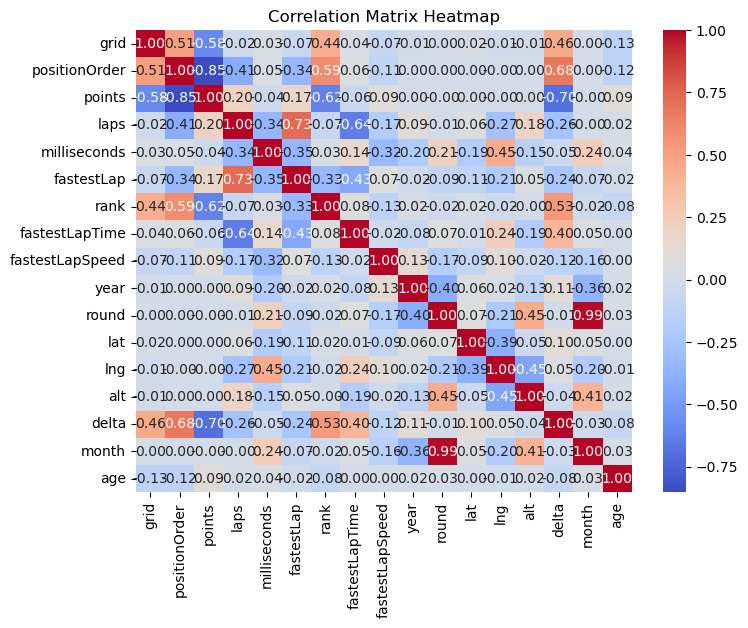

In [51]:
# Calculating correlation matrix
corr_matrix = data2223.corr()

# Creating a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap')
plt.show()

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [52]:
def vif(X):
    '''
    Calculate Variance Inflation Factor (VIF) for each feature to detect multicollinearity.

    Parameters:
    -----------
    X : pandas.DataFrame or array-like
        The feature matrix.

    Returns:
    --------
    None

    Notes:
    ------
    - Calculates VIF for each feature in the given feature matrix.
    - Identifies variables with moderate and high multicollinearity based on a threshold.
    - Prints the variables with moderate and high multicollinearity.
    '''
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Features"] = X.columns
    vif_data["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Set the threshold for high multicollinearity
    threshold = 5

    # Print variables with moderate multicollinearity
    moderate_multicollinearity = vif_data[vif_data["VIF Factor"] <= threshold].sort_values(by='VIF Factor', ascending=True)
    print("Variables with Moderate Multicollinearity:")
    print(moderate_multicollinearity)

    # Print variables with high multicollinearity
    print("\nVariables with High Multicollinearity (discard):")
    print(vif_data[vif_data["VIF Factor"] > threshold].sort_values(by='VIF Factor', ascending=True))


In [ ]:
races

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,1116,2023,18,69,United States Grand Prix,2023-10-22,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00
1097,1117,2023,19,32,Mexico City Grand Prix,2023-10-29,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N
1098,1118,2023,20,18,São Paulo Grand Prix,2023-11-05,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00
1099,1119,2023,21,80,Las Vegas Grand Prix,2023-11-19,06:00:00,https://en.wikipedia.org/wiki/2023_Las_Vegas_G...,2023-11-17,04:30:00,2023-11-17,08:00:00,2023-11-18,04:30:00,2023-11-18,08:00:00,\N,\N


In [74]:
data2223[data2223['status'] == '+6 Laps'].T

,576
grid,16.0
positionOrder,16.0
points,0.0
laps,47.0
milliseconds,NaN
fastestLap,25.0
rank,18.0
fastestLapTime,99368.0
fastestLapSpeed,211.649
year,2022.0


In [72]:
data2223['status'].value_counts()

Finished            442
+1 Lap              124
Collision damage     18
Collision            15
Accident             12
Engine               12
+2 Laps              11
Power Unit            6
Hydraulics            4
Gearbox               4
Oil leak              2
Water leak            2
Brakes                2
Fuel pressure         2
Water pressure        2
Undertray             2
Mechanical            2
Power loss            2
Spun off              2
Water pump            1
Withdrew              1
Cooling system        1
Suspension            1
Differential          1
+6 Laps               1
Retired               1
Overheating           1
Vibrations            1
Electrical            1
Fuel pump             1
Turbo                 1
Fuel leak             1
Front wing            1
Name: status, dtype: int64

# Modeling

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=21)

In [62]:
from sklearn.ensemble import RandomForestRegressor

In [63]:
rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=21)

In [64]:
rf.fit(X_train, y_train)

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values